In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import seaborn as sns
import time
import copy
import sys
from torch.utils.data import DataLoader
from voltron.data import make_ticker_list, GetStockHistory
sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 2.0})

Warning no robinhood utils.


## Dataset Setup

In [29]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, data, sequence_length=5):
        self.sequence_length = sequence_length
        self.X = data.float()

    def __len__(self):
        return self.X.shape[0]-1

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1)]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1).squeeze(-1)
            x = self.X[0:(i + 1)]
            x = torch.cat((padding, x), 0)
            
        return x.unsqueeze(0), self.X[i+1]

In [32]:
tckr = "JPM"
ntrain = 400
lookback = 1
pxs = GetStockHistory(tckr, end_date="2021-12-07", history=ntrain + lookback).Close.to_numpy()
data = torch.FloatTensor(pxs).log()

data = (data - data.mean())/data.std()


# xin = torch.linspace(0, 5*np.pi, 250)
# data = torch.sin(xin) + 0.2 * torch.randn(xin.shape)



In [33]:
seq_len = 25
dset = SequenceDataset(data, seq_len)

trgts = []
for i in range(len(dset)):
    trgts.append(dset[i][1].item())

In [34]:
train_loader = DataLoader(dset, batch_size=20, shuffle=True)
X, y = next(iter(train_loader))

In [35]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, input_size, hidden_units=128):
        super().__init__()
        self.input_size = input_size # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 5

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)
        

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        output = torch.zeros_like(out)
        output[:, 0] = out[:, 0]
        output[:, 1] = torch.exp(out[:, 1])
        return output
    
from torch.autograd import Variable  
class LSTM1(nn.Module):
    def __init__(self, num_classes, seq_len, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = seq_len #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=seq_len, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

        hn = hn[self.num_layers-1]
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        output = torch.zeros_like(out)
        output[:, 0] = out[:, 0]
        output[:, 1] = self.softplus(out[:, 1])
        return output

In [36]:
# model = ShallowRegressionLSTM(seq_len)
model = LSTM1(2, seq_len, 128, 1)

In [37]:
def NLL(targets, outputs):
    dist = torch.distributions.Normal(outputs[:, 0], outputs[:, 1])
    return -dist.log_prob(targets).sum()

In [38]:
def train_model(data_loader, model, loss_function, optimizer, epochs=200):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    for epoch in range(epochs):
        for X, y in data_loader:
            output = model(X)
            loss = loss_function(y, output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch%10 == 0:
            avg_loss = total_loss / num_batches
            print(f"Train loss: {avg_loss}, Epoch: {epoch}")

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(train_loader, model, NLL, optimizer)

Train loss: 9.58264362514019, Epoch: 0
Train loss: -7.665388387441635, Epoch: 10
Train loss: -96.57648058235645, Epoch: 20
Train loss: -222.45588295161724, Epoch: 30
Train loss: -393.4549728780985, Epoch: 40
Train loss: -557.4210761398077, Epoch: 50
Train loss: -733.938936367631, Epoch: 60
Train loss: -916.8391911536455, Epoch: 70
Train loss: -1094.614848962426, Epoch: 80


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/greg_b/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-1bf22962a03c>", line 2, in <module>
    train_model(train_loader, model, NLL, optimizer)
  File "<ipython-input-38-1b396ffa6e98>", line 11, in train_model
    loss.backward()
  File "/home/greg_b/miniconda3/lib/python3.8/site-packages/torch/_tensor.py", line 307, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/home/greg_b/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py", line 154, in backward
    Variable._execution_engine.run_backward(
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/greg_b/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2064, in showtraceback
  

TypeError: object of type 'NoneType' has no len()

In [40]:
means = []
vrs = []
for X, y in dset:
    output = model(X.unsqueeze(0))
    means = means + list(output[:, 0].detach().numpy())
    vrs = vrs + list(output[:, 1].detach().numpy())

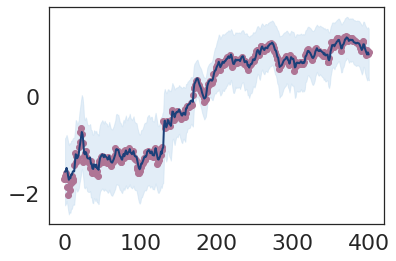

In [41]:
xx = torch.arange(data.shape[0])

plt.plot(xx[1:], means)
plt.fill_between(xx[1:], means - 2*np.sqrt(vrs), means + 2*np.sqrt(vrs), color=palette[1], alpha=0.5)
plt.scatter(xx, data, color=palette[5])

## Rollouts

In [42]:
nroll = 50
roll_len = 100
xin, xout = dset[len(dset)-1]
xx = torch.cat((xin[0, 1:], xout.unsqueeze(0)))
xx = xx.repeat(nroll, 1).unsqueeze(1)
roll_pxs = torch.zeros(nroll, roll_len)
with torch.no_grad():
    for idx in range(roll_len):
        out = model(xx)
        smpl = torch.normal(out[:, 0], out[:, 1])
        roll_pxs[:, idx] = smpl
        xx = torch.cat((xx[..., 1:], smpl.unsqueeze(-1).unsqueeze(-1)), -1)

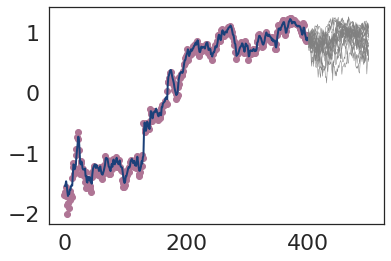

In [43]:
full_x = torch.arange(data.shape[0])
test_x = torch.arange(data.shape[0], data.shape[0] + roll_len)
plt.plot(full_x[1:], means)
plt.scatter(full_x, data, color=palette[5])
plt.plot(test_x, roll_pxs[:20, :].T.detach(), color='gray', alpha=1., lw=0.5)
plt.show()

## Just playing

In [44]:
import numpy as np
import torch
import gpytorch
import sys

sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP
from voltron.kernels import BMKernel, VolatilityKernel, FBMKernel
from voltron.models import BMGP, VoltronGP, MaternGP, SMGP, VoltMagpie
from voltron.means import LogLinearMean, EWMAMean, DEWMAMean, TEWMAMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.means import ConstantMean
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainVoltMagpieModel
from voltron.train_utils import TrainBasicModel, TrainVoltModel
from voltron.rollout_utils import GeneratePrediction


In [45]:
train_y = torch.FloatTensor(pxs).log()
train_x = (torch.arange(train_y.numel())/252.)[1:]
test_x = torch.arange(100)/252. + train_x[-1]

In [46]:
vol = LearnGPCV(train_x, train_y, train_iters=200,
                    printing=False)
vmod, vlh = TrainVolModel(train_x, vol,  
                          train_iters=200, printing=False)

In [47]:
voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
voltron = VoltronGP(train_x, train_y[1:], voltron_lh, vol)
voltron.mean_module = ConstantMean()

voltron.likelihood.raw_noise.data = torch.tensor([1e-5])
voltron.vol_lh = vlh
voltron.vol_model = vmod

In [48]:
voltron.train();
voltron_lh.train();
voltron.vol_lh.train();
voltron.vol_model.train();

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

print_every = 50
for i in range(400):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = voltron(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y[1:])
    loss.backward()
    if True:
        if i % print_every == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, 200, loss.item()))
    optimizer.step()


Iter 1/200 - Loss: 7.323
Iter 51/200 - Loss: 1.576
Iter 101/200 - Loss: 0.906
Iter 151/200 - Loss: -0.836
Iter 201/200 - Loss: -1.960
Iter 251/200 - Loss: -1.965
Iter 301/200 - Loss: -1.965
Iter 351/200 - Loss: -1.965


In [49]:
voltron.eval();
voltron_lh.eval();

In [50]:
pred_vols = vmod(test_x).sample(torch.Size((10,)))
samples = GeneratePrediction(train_x, train_y[1:], test_x, pred_vols.exp(), voltron)

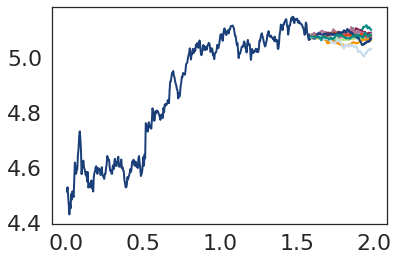

In [51]:
plt.plot(train_x, train_y[1:])
plt.plot(test_x, samples.T.detach());

## Check Volt + Constant Preds

In [52]:
preds = torch.load("./saved-outputs/AMZN/volt_constant2020-01-09.pt").cpu()
# preds = torch.load("../trading/saved-outputs/AMZN/volt_dewma100_2019-12-18.pt").cpu()

tckr = "AMZN"
ntrain = 400
lookback = 1
data = GetStockHistory(tckr, end_date="2019-12-18", 
                       history=ntrain + lookback).Close.to_numpy()

In [53]:
train_x = torch.arange(data.shape[0])
test_x = torch.arange(preds.shape[-1]) + train_x[-1]

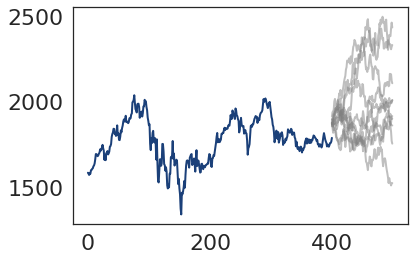

In [54]:
plt.plot(train_x, data)
plt.plot(test_x, preds[:10, :].T.exp(), color='gray', alpha=0.5);
# plt.ylim(1000, 5000)